In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np 
from datetime import datetime, timedelta
import holidays

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pywt

In [2]:
tf.__version__

'2.8.0'

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importing data and building dataset

In [4]:
data = pd.read_csv("../Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)
Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0
Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')
Electric.set_index('Date', inplace=True)

In [5]:
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data.Date)
data.loc[data.Hour == 24, 'Date'] = data.loc[data.Hour == 24, 'Date'] + timedelta(days=1)
data.loc[data.Hour == 24, 'Hour'] = 0
data.Date = pd.to_datetime(data.Date.astype(str) + ' ' + data['Hour'].astype(str) + ':' + data.Minute.astype(str) + ':00')
data.set_index('Date', inplace=True)

fig_width_pt = 222.62206                # Get this from LaTeX using \the\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches

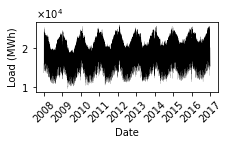

In [6]:
plt.figure(figsize=(fig_width, fig_height), constrained_layout=True)
plt.plot(data.Load, c='k', linewidth=0.1)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Load (MWh)')
#plt.title('Poland electricity consumption', fontsize=10)

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

ax = plt.gca()
ax.yaxis.set_major_formatter(formatter) 

#plt.savefig('Poland_Load.png', dpi=2000, transparent=False)

# Resampling the signal

In [7]:
resample_cost = 'd'
Electric_day = Electric.resample(resample_cost).agg({'Hour': np.mean, 'Minute': np.mean, 'Load': np.sum})
Electric_day.reset_index(inplace=True)
Electric_day.loc[Electric_day.Load < 20000, 'Load'] = np.nan
Electric_day.Load.interpolate(inplace=True)

Electric_day['Seconds'] = (Electric_day.Date - Electric_day.Date[0]).dt.total_seconds()
Electric_day = Electric_day[['Date', 'Seconds', 'Load']]
Electric_day['Day'] = Electric_day['Date'].dt.day_of_week
Electric_day['Minutes'] = Electric_day['Date'].dt.minute
Electric_day['Hour'] = Electric_day['Date'].dt.hour

In [8]:
Load_min, Load_max, Load_mean = Electric_day['Load'].min(), Electric_day['Load'].max(), Electric_day['Load'].mean() 
Electric_day['Load'] = (Electric_day['Load'] - Load_mean)/ (Load_max - Load_min) 

<AxesSubplot:>

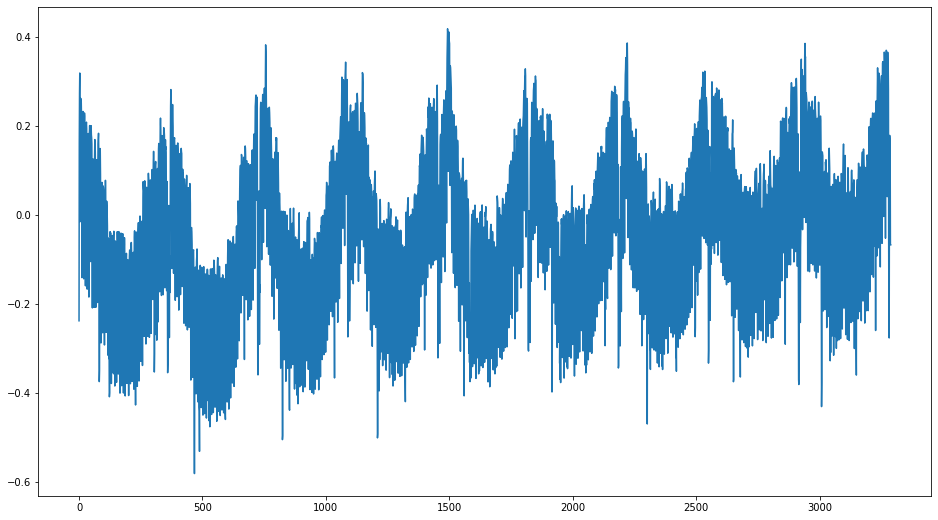

In [9]:
Electric_day.Load.plot(figsize=(16,9))

In [10]:
def series_to_supervised(series, n_in=96, n_out=1, dropnan=True, batch_size=1):
    dataset = tf.data.Dataset.from_tensor_slices(series.to_numpy())
    dataset = dataset.window(n_in, shift=n_out, drop_remainder=dropnan)
    dataset = dataset.flat_map(lambda window: window.batch(96))
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [11]:
val_time = int(len(Electric_day.Load) * 0.80)
n_forecast = 10 
test_time = -n_forecast

# How much data from the past should we need for a forecast?
window_len = 96 # nearly 13 weeks
# How far ahead do we want to generate forecasts?
forecast_len = 10 # 1 day


batch_size = 1024

training_data = Electric_day.iloc[:val_time]['Load']
validation_data = Electric_day.iloc[val_time:test_time]['Load']
test_data = Electric_day.iloc[test_time:]['Load']

Train_dataset = series_to_supervised(training_data, 
                                        window_len, 
                                        forecast_len, batch_size=batch_size)

Val_dataset = series_to_supervised(validation_data, 
                                        window_len, 
                                        forecast_len, batch_size=batch_size)

In [22]:
model_many_to_one = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                         strides=1, padding="causal",
                         activation="relu", input_shape=(1, window_len)),  # None = Model can take sequences of any length
    tf.keras.layers.LSTM(128, activation="tanh", return_sequences=True),
    tf.keras.layers.LSTM(64, activation="tanh", return_sequences=False),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(forecast_len),
    tf.keras.layers.Lambda(lambda x: x * 100)  # LSTM's tanh activation returns between -1 and 1. Scaling output to same range of values helps learning.
])

# Note: to turn this into a classification task, just add a sigmoid function after the last Dense layer and remove Lambda layer.

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model_many_to_one.compile(loss=tf.keras.losses.Huber(), # Huber is less sensitive to outliers
                          optimizer=optimizer,
                          metrics=["mae"])
#tf.keras.utils.plot_model(model_many_to_one, show_shapes=True)

# Model building/training (point predictions)

In [23]:
model_many_to_one.fit(Train_dataset, epochs=100, validation_data=Val_dataset);

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.1562 - mae: 0.4377 - val_loss: 0.1860 - val_mae: 0.4738
Epoch 2/100
1/1 [==============================] - 0s 441ms/step - loss: 0.1487 - mae: 0.4237 - val_loss: 0.1695 - val_mae: 0.4408
Epoch 3/100
1/1 [==============================] - 0s 453ms/step - loss: 0.1357 - mae: 0.3989 - val_loss: 0.1494 - val_mae: 0.4000
Epoch 4/100
1/1 [==============================] - 0s 444ms/step - loss: 0.1196 - mae: 0.3675 - val_loss: 0.1284 - val_mae: 0.3560
Epoch 5/100
1/1 [==============================] - 0s 461ms/step - loss: 0.1030 - mae: 0.3345 - val_loss: 0.1087 - val_mae: 0.3157
Epoch 6/100
1/1 [==============================] - 0s 458ms/step - loss: 0.0875 - mae: 0.3036 - val_loss: 0.0919 - val_mae: 0.2811
Epoch 7/100
1/1 [==============================] - 0s 452ms/step - loss: 0.0745 - mae: 0.2768 - val_loss: 0.0788 - val_mae: 0.2541
Epoch 8/100
1/1 [==============================] - 0s 442ms/step - loss: 0.0643 - mae:

In [30]:
def get_preds(model, val_data):
    series = tf.expand_dims(val_data, axis=1)
    tf_val_data = tf.data.Dataset.from_tensor_slices(series)
    #tf_val_data = tf_val_data.window(96, shift=forecast_len, drop_remainder=False)
    #tf_val_data = tf_val_data.flat_map(lambda x: x.batch(96))
    #tf_val_data = tf_val_data.batch(1).prefetch(1)
    forecast = model.predict(tf_val_data)
    # forecast = forecast * 10
    return forecast.reshape(-1)

In [37]:
np.asarray([res, res1]).mean(axis=0)

array([ 0.2382211 ,  0.20167351, -0.07121585,  0.295308  ,  0.73093   ,
       -0.46964818, -0.73888505,  0.12436826,  0.19799499,  0.06497501],
      dtype=float32)

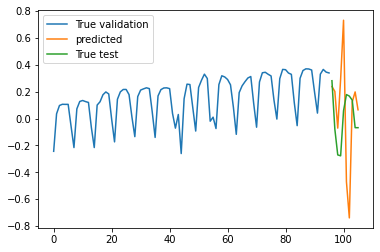

In [31]:
res1 = get_preds(model_many_to_one, validation_data.values[-96:].reshape(1,-1))

plt.plot(validation_data.values[-96:], label='True validation')
plt.plot(range(window_len, window_len + n_forecast), res, label='predicted')
plt.plot(range(window_len, window_len + n_forecast), test_data.values, label='True test')
plt.legend()

# Forecasting with distributions

In [40]:
from tqdm import tqdm

def fit_model(X_train, X_validation):
    model_many_to_one = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
        tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                               strides=1, padding="causal",
                               activation="relu", input_shape=(1, window_len)),  # None = Model can take sequences of any length
        tf.keras.layers.LSTM(128, activation="tanh", return_sequences=True),
        tf.keras.layers.LSTM(64, activation="tanh", return_sequences=False),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(forecast_len),
        tf.keras.layers.Lambda(lambda x: x * 100)  # LSTM's tanh activation returns between -1 and 1. Scaling output to same range of values helps learning.
    ])

    # Note: to turn this into a classification task, just add a sigmoid function after the last Dense layer and remove Lambda layer.
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
    model_many_to_one.compile(loss=tf.keras.losses.Huber(), # Huber is less sensitive to outliers
                              optimizer=optimizer,
                              metrics=["mae"])
    model_many_to_one.fit(X_train, epochs=100, validation_data=X_validation, verbose=0)
    return model_many_to_one

    
def fit_ensemble(n_sim, X_train, X_validation):
    ensemble = []
    for i in tqdm(range(n_sim)):
        model = fit_model(X_train, X_validation)
        
        #store the models
        ensemble.append(model)
    return ensemble


def ensemble_predictions(ensemble, X_last, forecast_time, window_len):
    pred = []
    for i, model in enumerate(ensemble):
        pred.append(get_preds(model, X_last))
    
    pred = np.asarray(pred)
    y_hat = pred.mean(axis=0)
    interval = 1.96 * pred.std(axis=0)
    lower, upper = y_hat - interval, y_hat + interval
    return lower, y_hat, upper

In [41]:
ensemble = fit_ensemble(100, Train_dataset, Val_dataset)
X_test = validation_data.values[-window_len:]
lower, mean, upper = ensemble_predictions(ensemble, X_test, n_forecast, window_len)

  2%|▏         | 2/100 [02:11<1:47:09, 65.61s/it]


KeyboardInterrupt: 

Text(0, 0.5, 'Daily Load')

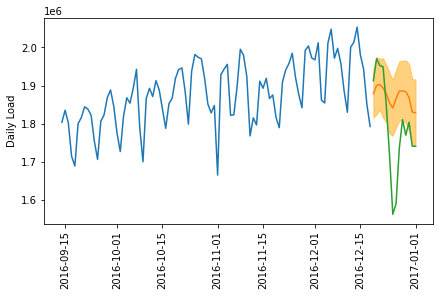

In [24]:
x = Electric_day.iloc[-(window_len + n_forecast):]['Date'].values

plt.figure(constrained_layout=True)
plt.plot(x[:-n_forecast], X_test * (Load_max - Load_min) + Load_mean, label='True validation')
plt.plot(x[-n_forecast:], mean * (Load_max - Load_min) + Load_mean, label='predicted')
plt.fill_between(x[-n_forecast:], y1=lower * (Load_max - Load_min) + Load_mean, 
                 y2=upper * (Load_max - Load_min) + Load_mean, label='CI 95%', color='orange', alpha=0.5)
plt.plot(x[-n_forecast:], test_data.values * (Load_max - Load_min) + Load_mean, label='True test')
plt.xticks(rotation='vertical')
plt.ylabel('Daily Load')

# Plotting results for the report

In [25]:
x = Electric_day.iloc[-(window_len + n_forecast):]['Date']
cols = ['Load_mean', 'Load_low', 'Load_up']
Electric_day.loc[Electric_day.Date.isin(x[-n_forecast:]), cols] = np.column_stack((mean, lower, upper))
Electric_day.to_csv('lstm_results.csv', index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


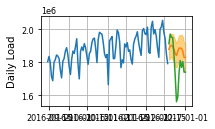

In [26]:
fig_width_pt = 222.62206                # Get this from LaTeX using \the\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

x = Electric_day.iloc[-(window_len + n_forecast):]['Date']

plt.figure(constrained_layout=True)
plt.plot(x[:-n_forecast], X_test * (Load_max - Load_min) + Load_mean, label='True validation')
plt.plot(x[-n_forecast:], mean * (Load_max - Load_min) + Load_mean, label='predicted')
plt.fill_between(x[-n_forecast:], y1=lower * (Load_max - Load_min) + Load_mean, 
                 y2=upper * (Load_max - Load_min) + Load_mean, label='CI 95%', color='orange', alpha=0.5)
plt.plot(x[-n_forecast:], test_data.values * (Load_max - Load_min) + Load_mean, label='True test')
#plt.xticks(rotation='vertical')
plt.ylabel('Daily Load')
plt.grid()
plt.tight_layout()
#plt.legend()
plt.savefig("./NN_LSTM_predictions.png", dpi=800, transparent=False)
